### Teste de hipotese

Esse notebook tem por objetivo detectar varios pontos e gerar um descritor otimo que seja resitente a variacoes de transformacoes afins e pequenas transformacoes projetivas, para isso temos:

-- BaseFeatures para extrair informacoes equivariantes (num_channels,dim_first,dim_second,dim_third).

-- SingularPoints lida com escala , e extrai as features consolidadas, em dim_third caracteristicas distintas, orientacao computadas além da lista de pontos.

-- Computa a funcao de perda entre os mapas de orientacao e feature e os pontos que colidiram

In [47]:
# !git clone -b siamese https://github.com/wagner1986/singular-points.git singular_points
# !pip install kornia e2cnn

# !pwd
# %cd /content/singular_points
# !pwd

In [48]:
import torch
from e2cnn import gspaces
from e2cnn import nn as enn    #the equivariant layer we need to build the model
from torch import nn
import numpy as np

In [49]:
from config import args, device
def custom_config(args):
    args.num_channels = 3
    args.img_size = 120
    args.dim_first = 3
    args.dim_second = 5
    args.dim_third = 8
    args.batch_size = 20
    args.margin_loss = 2.0
    args.border_size  = 12
    args.nms_size = 5 # normal é 10, alterei so pra avaliar o match
    args.box_size = 21
    args.exported = False
    return args

POINTS_LIMIT = 60
THRESHOLD_COLLISION = 1.0
args = custom_config(args)

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [50]:
def criar_mascara(size_batch,dimensao_janela, tamanho_borda):
    
    mascara = torch.zeros((size_batch,args.num_channels, dimensao_janela, dimensao_janela), dtype=torch.uint8)
    mascara[..., tamanho_borda:-tamanho_borda, tamanho_borda:-tamanho_borda] = 1

    return mascara.to(torch.float32)

In [51]:
class MaxPointDetector:
    """
    Class for detecting maximum points in images or tensors.

    Methods:
    - detect_max_points: Applies a maximum point filter on a batch of images.
    - filter_coordinates: Filters coordinates in a tensor based on image and channel indices.
    - Sorts the rows of a matrix based on the last element of each row.
    """

    def detect_max_points(self, images, size=15, threshold=1e-3):
        width, height = images.shape[-2:]
        max_map = F.max_pool2d(images, size, stride=1, padding=(size - 1) // 2)

        max_coords = (max_map > threshold) & (max_map == images)
        max_coords = max_coords.nonzero()
        max_values = max_map[max_coords[:, 0], max_coords[:, 1], max_coords[:, 2], max_coords[:, 3]]

        max_coords_values = torch.cat((max_coords, max_values.unsqueeze(1)), dim=1)
        max_coords_values = max_coords_values[:, [0, 1, 3, 2, 4]]  # trocando x e y de ordem antes de concatenar

        # Filtrar coordenadas na borda
        mask = (
            (max_coords_values[:, 2] >= args.border_size) &  # Verificar limite esquerdo
            (max_coords_values[:, 2] < (width - args.border_size)) &  # Verificar limite direito
            (max_coords_values[:, 3] >= args.border_size) &  # Verificar limite superior
            (max_coords_values[:, 3] < (height - args.border_size ))  # Verificar limite inferior
        )
        max_coords_values = max_coords_values[mask]
        
        return max_coords_values, max_map.squeeze().numpy()
    
    def sort_tensor_by_columns(self,tensor):
        # Ordena pela última coluna
        sorted_indices = torch.argsort(tensor[:, -1],descending=True)
        tensor_sorted_by_last_column = tensor[sorted_indices]
        return tensor_sorted_by_last_column
    
    def filter_coordinates(self, tensor, image_index, channel_index):
        # Filter the values where the image and channel indices are equal to the provided values
        mask = (tensor[:, 0] == image_index) & (tensor[:, 1] == channel_index)
        filtered_coords = torch.masked_select(tensor[:, 2:], mask.unsqueeze(1)).reshape(-1, 3)
        return filtered_coords


def check_valid_points(points, mask):
    # Check limits of points
    height_mask, width_mask = mask.shape[-2:]
    limits_valid = (points[..., 0].long() >= 0) & (points[..., 0].long() < width_mask) & (points[..., 1].long() >= 0) & (points[..., 1].long() < height_mask)

    # Check if points are within the mask region with value equal to 1
    mask_valid = torch.ones_like(limits_valid)
    if mask is not None:
        mask_valid = mask[..., points[..., 1].long().unsqueeze(-1), points[..., 0].long().unsqueeze(-1)] == 1

    # Combine the checks to get the valid points
    valid_points = points[limits_valid & mask_valid.squeeze()]

    return valid_points

In [52]:
r2_act = gspaces.Rot2dOnR2(N=args.group_size)#N=8 is the number of Groups equivariant
OUT_SHAPE = args.img_size
#This model is base to build the model for singular points detection e orientation estimation
class BaseFeatures(nn.Module):
    #This model extract 8 features from the image
    def __init__(self, args) -> None:
        super().__init__()
        self.pyramid_levels = args.pyramid_levels
        self.scale = args.scale_pyramid
        self.feat_type_in = enn.FieldType(r2_act, args.num_channels * [
            r2_act.trivial_repr])  ## input 1 channels (gray scale image)

        #feat_type_out1 = enn.FieldType(r2_act, args.dim_first * [r2_act.regular_repr])
        feat_type_out1 = enn.FieldType(r2_act, args.dim_second * [r2_act.regular_repr])
        feat_type_out2 = enn.FieldType(r2_act, args.dim_second * [r2_act.regular_repr])
        feat_type_out3 = enn.FieldType(r2_act, args.dim_third * [r2_act.regular_repr])

        self.block1 = enn.SequentialModule(
            enn.R2Conv(self.feat_type_in, feat_type_out1, kernel_size=5, padding=2, bias=False),
            enn.InnerBatchNorm(feat_type_out1),
            enn.ReLU(feat_type_out1, inplace=True),
        )
        self.block2 = enn.SequentialModule(
            enn.R2Conv(feat_type_out1, feat_type_out2, kernel_size=5, padding=2, bias=False),
            enn.InnerBatchNorm(feat_type_out2),
            enn.ReLU(feat_type_out2, inplace=True)
        )
        self.block3 = enn.SequentialModule(
            enn.R2Conv(feat_type_out2, feat_type_out3, kernel_size=5, padding=2, bias=False),
            enn.InnerBatchNorm(feat_type_out3),
            enn.ReLU(feat_type_out3, inplace=True),
            enn.PointwiseAdaptiveAvgPool(feat_type_out3,OUT_SHAPE),
        )
    
    def forward(self, x):
        x = enn.GeometricTensor(x, self.feat_type_in)        
        x = self.block1(x)
        # x = self.block2(x)
        x = self.block3(x)        
        return x


In [53]:
import torch.nn.functional as F
from kornia import filters

class SingularPoints(nn.Module):
    def __init__(self,args) -> None:
        super().__init__()
        print(args)
        self.in_type = enn.FieldType(r2_act, args.dim_third * [r2_act.regular_repr])
        feat_type_ori_est = enn.FieldType(r2_act, [r2_act.regular_repr])
        
        self.pyramid_levels = args.pyramid_levels
        self.scale_pyramid = args.scale_pyramid
        self.n_channel = args.num_channels
        
        self.base = BaseFeatures(args)
        
        self.gpool = enn.GroupPooling(self.in_type)#feature pooling
        self.ori_learner = enn.SequentialModule(
            enn.R2Conv(self.in_type, feat_type_ori_est, kernel_size=1, padding=0, bias=False),         
        )
        
        self.softmax = torch.nn.Softmax(dim=1)
        self.last_layer_features = torch.nn.Sequential(
            torch.nn.BatchNorm2d(num_features=args.dim_third * self.pyramid_levels),
            torch.nn.Conv2d(in_channels=args.dim_third * self.pyramid_levels, out_channels=args.dim_third, kernel_size=1, bias=True),
            torch.nn.LeakyReLU(inplace=True)  ## clamp to make the scores positive values.
        )
        
        self.features_summary = torch.nn.Sequential(
            torch.nn.BatchNorm2d(num_features=args.dim_third),
            torch.nn.Conv2d(in_channels=args.dim_third, out_channels=1, kernel_size=1, bias=True),
            torch.nn.LeakyReLU(inplace=True)  ## clamp to make the scores positive values.
        )
        
        self.detector = MaxPointDetector()
        
    def resize_pyramid(self,idx_level,input_data):
        gaussian = filters.GaussianBlur2d((3, 3), (0.9, 0.9))
        input_data_blur = gaussian(input_data)

        size = np.array(input_data.shape[-2:])
        new_size = (size / (self.scale_pyramid ** idx_level)).astype(int)

        input_data_resized = F.interpolate(input_data_blur, size=tuple(new_size), align_corners=True, mode='bilinear')
        return input_data_resized
    
    def compute_gradient_direction(self,orie_img_batch):
        _b,_na,_c,_r=orie_img_batch.shape #bacth,num degree,col,row
        ori_arg_max= torch.argmax(orie_img_batch, dim=1)
        bin_size = 360/_na
        ori_arg_max=ori_arg_max*bin_size # direcao do gradiente
                                # para cada pixel
        ori_arg_max=ori_arg_max[None].permute(1, 0, 2, 3)
        return ori_arg_max

    def forward(self,x)->torch.Tensor:
        for idx_level in range(self.pyramid_levels):
            with torch.no_grad():
                input_data_resized = self.resize_pyramid(idx_level,x)
            x_base = self.base(input_data_resized)
           
            features_t = self.gpool(x_base).tensor# C*G -> 1*C
            features_o = self.ori_learner(x_base).tensor # C*G -> 1*G            
            
            if idx_level == 0:
                features_key = features_t
                features_ori = features_o
            else:
                features_key = torch.cat([features_key, features_t], axis=1)  # concatena no eixo X (S*C)
                features_ori = torch.add(features_ori, features_o)  # somatorio dos kernels            
            # print('features_key ',features_key.shape,' features_ori ',features_ori.shape) #TODO: remover
        
        features_key = self.last_layer_features(features_key)#(S*C)->(1*C)
        features_key_summary = self.features_summary(features_key)#(C)->(1)
        
        features_ori = self.softmax(features_ori)
        features_ori_summary = self.compute_gradient_direction(features_ori)
               
        return  features_key,features_key_summary,features_ori,features_ori_summary
    

model=SingularPoints(args).to(device)

Namespace(exported=False, num_channels=3, pyramid_levels=3, scale_pyramid=1.3, dim_first=3, dim_second=5, dim_third=8, group_size=36, epochs=80, border_size=12, box_size=21, nms_size=5, img_size=120, batch_size=20, path_data='./data', path_model='model.pt', is_loss_ssim=True, margin_loss=2.0, outlier_rejection=False, show_feature=False)


In [54]:

from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
import time

def medir_tempo(linha_codigo):
    start_time = time.time()
    resultado = linha_codigo()
    end_time = time.time()
    execution_time = end_time - start_time
    return resultado, execution_time
    
def plot_images_side_by_side(tensor_images):
    b, x, y = tensor_images.shape

    # Criar uma figura e eixos para o plot
    fig, axes = plt.subplots(1, b, figsize=(b*3, 3))

    # Loop sobre as imagens e plotar cada uma em um eixo separado
    for i in range(b):
        # Obter a imagem atual
        image = tensor_images[i]

        # Plotar a imagem no eixo correspondente
        axes[i].imshow(image, cmap='gray')  # Defina cmap='gray' se as imagens forem em escala de cinza
        axes[i].axis('off')  # Desabilitar os eixos

    # Exibir o plot
    plt.show()
    
def plot_matches_keypoints(image1, keypoints1, image2, keypoints2, matches, **kwargs):
    # Concatenar as duas imagens lado a lado
    combined_image = np.concatenate((image1.cpu(), image2.cpu()), axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(combined_image, cmap='gray')
    ax.axis('off')

    # Desenhar pontos correspondentes e linhas conectando-os
    offset = image1.shape[1]

    for i, (x, y) in enumerate(keypoints1.cpu()):
        ax.plot(x, y, 'o',markerfacecolor='none', markeredgecolor='g',
                markersize=20, markeredgewidth=1)
        ax.annotate(str(i), (x, y), color='g',xytext=(10, 10), textcoords='offset points', fontsize=12)

    for i, (x, y) in enumerate(keypoints2.cpu()):
        ax.plot(x+offset, y, 'o',markerfacecolor='none', markeredgecolor='g',
                markersize=20, markeredgewidth=1)
        ax.annotate(str(i), (x+offset, y), color='g',xytext=(10, 10), textcoords='offset points', fontsize=12)

    for match in matches:
        x1, y1 = keypoints1[match[0],0], keypoints1[match[0],1]
        x2, y2 = keypoints2[match[1],0]+offset, keypoints2[match[1],1]
        ax.plot([x1, x2], [y1, y2], '-', color='lime', lw=0.5)

    plt.tight_layout()
    plt.show()


def find_best_matching_indices_knn(points1, points2, threshold, k=3):
    distances = cdist(points1, points2)
    best_indices = np.argsort(distances, axis=1)[:, :k]
    best_distances = np.take_along_axis(distances, best_indices, axis=1)

    matched = []

    for i in range(len(points1)):
        min_distance = np.min(best_distances[i])
        if min_distance < threshold:
            best_index = np.argmin(best_distances[i])
            matched.append((i, best_indices[i, best_index]))

    return matched


def find_matching_in_batch(batch_points1, batch_points2, threshold):
    # Lista para armazenar as correspondências
    lista_correspondencias = []

    # Iterar sobre o lote de pontos
    for i in range(batch_points1.shape[0]):
        # Obter os pontos correspondentes entre duas imagens
        correspondencias = find_best_matching_indices_knn(batch_points1[i], batch_points2[i], threshold)
        lista_correspondencias.append(correspondencias)

    return lista_correspondencias

def predict_all_points(input_data,mask):
    features_key,features_key_summary,features_ori,features_ori_summary,max_coords_values, max_map= model(input_data*mask)
    max_coords_temp = model.detector.sort_tensor_by_columns(max_coords_values)
    batch_size = features_key.shape[0]
    batch_points = torch.zeros((batch_size,POINTS_LIMIT, 2))
    for i in range(batch_size):
        max_coords_temp2 = model.detector.filter_coordinates(max_coords_temp, image_index=i, channel_index=0)[:POINTS_LIMIT, :2]
    
        try:
            batch_points[i,:max_coords_temp2.shape[0]] = max_coords_temp2
        except:
            print(max_coords_temp2.shape,batch_points.shape)
            print('nao tem pontos suficientes')
    return features_key_summary,features_ori_summary,batch_points


def predict_all_descritor(input_data,mask):
    features_key,features_key_summary,features_ori,features_ori_summary,max_coords_values, max_map= model(input_data*mask)    
    max_coords_temp = model.detector.sort_tensor_by_columns(max_coords_values)
    batch_size = features_key.shape[0]
    batch_points = torch.zeros((batch_size,POINTS_LIMIT, 2))
    for i in range(batch_size):
        max_coords_temp2 = model.detector.filter_coordinates(max_coords_temp, image_index=i, channel_index=0)[:POINTS_LIMIT, :2]
    
        try:
            batch_points[i,:max_coords_temp2.shape[0]] = max_coords_temp2
        except:
            print(max_coords_temp2.shape,batch_points.shape)
            print('nao tem pontos suficientes')
    return features_key,features_ori,batch_points

### Predizer Segrega os pontos para cada imagem do batch

In [55]:
torch.cuda.empty_cache()

X1=torch.rand(4,args.num_channels,args.img_size,args.img_size).to(device)
mask = criar_mascara(X1.shape[0],X1.shape[-1],args.border_size).to(device)
print("mask.shape:", mask.shape)

features_key_summary,features_ori_summary,batch_points=predict_all_points(X1,mask)
print(features_key_summary.shape,features_ori_summary.shape,batch_points.shape)
# batch_t,mask_t,features_summary_t,features_ori_t,batch_points_t = transformations(X1,mask,features_summary,features_ori,batch_points.to(device))# transformar orientacoes e pontos
print("features_summary.shape:", features_key_summary.shape," batch_points.shape:", batch_points.shape)


mask.shape: torch.Size([4, 3, 120, 120])
torch.Size([4, 1, 120, 120]) torch.Size([4, 1, 120, 120]) torch.Size([4, 60, 2])
features_summary.shape: torch.Size([4, 1, 120, 120])  batch_points.shape: torch.Size([4, 60, 2])


### Aplicar transformação na imagem e suas predicoes

In [56]:
import kornia.augmentation as K
transformations = K.AugmentationSequential(
    K.RandomAffine(degrees=180, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=10,p=0.8),
    same_on_batch=True,
    data_keys = ['input','input', 'keypoints']  # Especificando as chaves de dados
)
out,mask_trans, transform = transformations(X1,mask,batch_points.to(device))  # 2x3x224x224 / 2x3x3
# prever os pontos da imagem transformada
features_key_summary2,features_ori_summary2,batch_points2 =predict_all_points(out,mask_trans)
print("features_summary2.shape:", features_key_summary2.shape," batch_points2.shape:", batch_points2.shape)

features_summary2.shape: torch.Size([4, 1, 120, 120])  batch_points2.shape: torch.Size([4, 60, 2])


points1.shape: (60, 2)  points2.shape: (60, 2)
points1[0] -> points2[0]
points1[2] -> points2[1]
points1[3] -> points2[16]
points1[4] -> points2[3]
points1[5] -> points2[12]
points1[6] -> points2[14]
points1[7] -> points2[9]
points1[8] -> points2[4]
points1[10] -> points2[5]
points1[13] -> points2[8]
points1[15] -> points2[11]
points1[16] -> points2[15]
points1[17] -> points2[7]
points1[18] -> points2[6]
points1[23] -> points2[38]
points1[24] -> points2[48]
points1[26] -> points2[28]
points1[30] -> points2[31]
points1[35] -> points2[41]
points1[36] -> points2[30]
points1[37] -> points2[55]
points1[39] -> points2[43]
points1[44] -> points2[53]
points1[48] -> points2[26]
points1[50] -> points2[47]
points1[51] -> points2[19]
points1[52] -> points2[25]
points1[53] -> points2[18]
points1[56] -> points2[19]
points1[57] -> points2[58]
points1[58] -> points2[39]
cuda:0 cuda:0 cuda:0


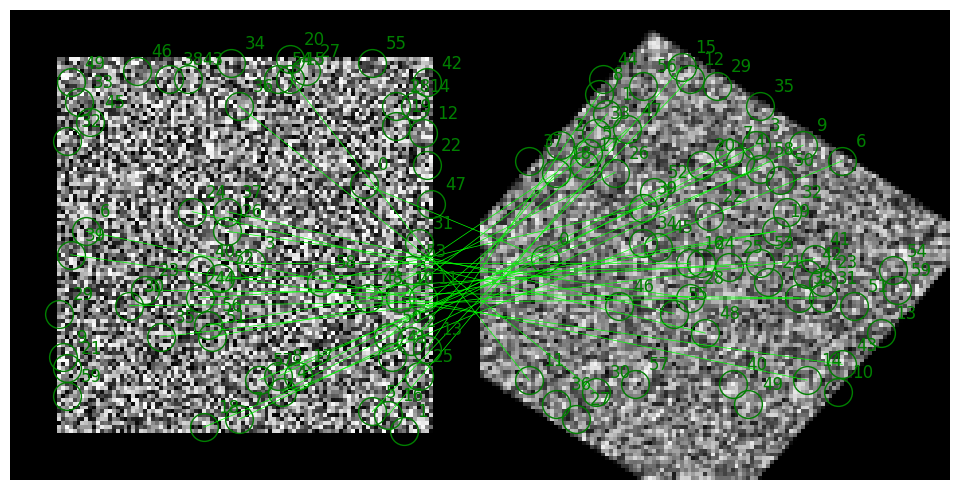

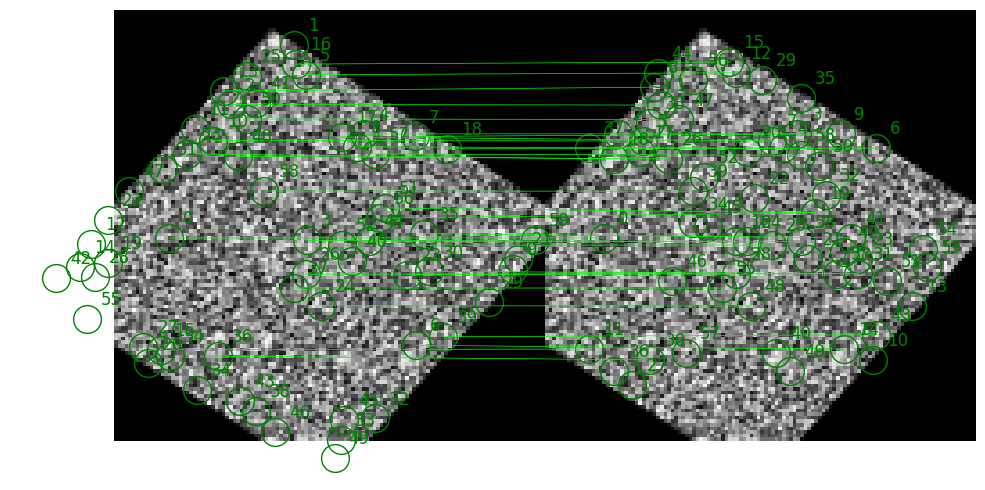

In [57]:
# Exemplo de uso
points1 = transform[0].cpu().numpy()
points2 = batch_points2[0].cpu().numpy()
threshold = 2.0
print("points1.shape:", points1.shape," points2.shape:", points2.shape)
matched = find_best_matching_indices_knn(points1, points2, threshold,k=3)
for (idx1,idx2) in matched:
    print(f"points1[{idx1}] -> points2[{idx2}]")

print(mask_trans.device,transform.device,mask.device)
plot_matches_keypoints(X1[0,0]*mask[0,0], batch_points[0].cpu(), out[0,0]*mask_trans[0,0], batch_points2[0].cpu(),matched)
plot_matches_keypoints(out[0,0]*mask_trans[0,0], transform[0].cpu(), out[0,0]*mask_trans[0,0], batch_points2[0].cpu(),matched)

### Treinamento

In [58]:
import math
import torchvision
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR
from torchvision.transforms import transforms, InterpolationMode

transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# transform = transforms.Compose([
#     transforms.Resize((args.img_size, args.img_size), interpolation=InterpolationMode.BICUBIC),
#     transforms.Grayscale(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5), (0.5))
# ])


trainset = torchvision.datasets.Flowers102(root='./data/datasets', split='train',
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size,
                                        shuffle=False, num_workers=2)

testset = torchvision.datasets.Flowers102(root='./data/datasets', split='test',
                                        download=True, transform=transform)

num_datapoints_to_keep = math.ceil(len(testset) / 2)
indices_to_keep = torch.randperm(num_datapoints_to_keep)[:num_datapoints_to_keep]
reduced_testset = torch.utils.data.Subset(testset, indices_to_keep)
testloader = torch.utils.data.DataLoader(reduced_testset, batch_size=args.batch_size,
                                        shuffle=False, num_workers=2)


In [59]:
from tqdm.notebook import tqdm
import gc
from training import triplet_loss 
from training.tensor_augmetation import shifted_batch_tensor

transformations = K.AugmentationSequential(
    K.RandomAffine(degrees=180, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=10,p=0.8),
    same_on_batch=True,
    data_keys = ['input','input','input', 'input','keypoints']  # Especificando as chaves de dados
)

# def loss_point(lista_correspondencias,n_pontos=20):
#     acertos = 0
#     qtd_batch =len(lista_correspondencias)
#     margin = n_pontos*0.25
#     for correspondencias in lista_correspondencias:
#         acertos += len(correspondencias)/qtd_batch
#     erros = n_pontos - acertos
#     loss = max(0, erros - acertos + margin)

#     return torch.tensor(loss*qtd_batch, requires_grad=True,dtype=torch.float).to(device)

def loss_point(lista_correspondencias,n_pontos=20):
    acertos = 0
    qtd_batch =len(lista_correspondencias)
    weight = 1
    for correspondencias in lista_correspondencias:
        acertos += (len(correspondencias)/n_pontos)/qtd_batch
    erros = (1 - acertos)
    loss = erros*weight
    return torch.tensor(loss, requires_grad=True,dtype=torch.float).to(device)

def train_one_epoch(model, train_loader, loss_map, loss_point, optimizer=None, device='cpu', transformations=None,is_training=True):
    model.train(is_training) # Set model to training mode
    total_loss = 0.
    desc="Train " if is_training else "Test "
    t = tqdm(train_loader, desc=desc)
    batch_i = 0
    loss_maps = 0.
    for batch_image, labels in t:
        batch_image = batch_image.to(device)
        mask = criar_mascara(batch_image.shape[0],batch_image.shape[-1],args.border_size).to(device)
        features_key_summary,features_ori_summary=predict_all_points(batch_image,mask)         
        batch_t,mask_t,features_key_summary_t,features_ori_summary_t,batch_points_t = transformations(batch_image,mask,features_key_summary,features_ori_summary,batch_points.to(device))# transformar orientacoes e pontos
        features_key_summary_t2,features_ori_summary_t2,batch_points_t2 =predict_all_points(batch_t,mask_t)# prever os pontos da imagem transformada
        lista_correspondencias = find_matching_in_batch(batch_points_t2.cpu(),batch_points_t.cpu(),threshold=THRESHOLD_COLLISION)
        
        batch_image_neg_trans, features_key_summary_neg, features_ori_summary_neg = shifted_batch_tensor(batch_t, features_key_summary_t2,
                                                                    features_ori_summary_t2)  # faz o shift com o comando roll(x,1,0)
        
        loss_maps = loss_map(features_key_summary_t,features_key_summary_t2,features_key_summary_neg)+loss_map(features_ori_summary_t,features_ori_summary_t2,features_ori_summary_neg)
        loss_col = loss_point(lista_correspondencias, n_pontos=POINTS_LIMIT)
        loss = loss_maps / 2 + loss_col

        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        t.set_description("{} Loss: {:.5f}".format(desc,loss))
        del features_key_summary, features_ori_summary, batch_points
        del batch_t, mask_t, features_key_summary_t, features_ori_summary_t, batch_points_t
        del features_key_summary_t2, features_ori_summary_t2, batch_points_t2
        gc.collect()
        torch.cuda.empty_cache()
        batch_i += 1
    return total_loss/batch_i


criterion_d = triplet_loss(is_ssim=args.is_loss_ssim, margim=args.margin_loss)

In [60]:
import torch

def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def load_model(model, filepath):
    model.load_state_dict(torch.load(filepath))
    model.eval()
    print(f"Model loaded from {filepath}")
    

# teste = model.copy()
path_siamese = './data/models/sp_53.pth'


In [61]:
gc.collect()
torch.cuda.empty_cache()
args.epochs=3
i_epoch = 0
loss = 0
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.75)

import torch

def train_with_early_stopping(model, trainloader, testloader, criterion_d, loss_point, optimizer, scheduler, device, transformations, epochs=100, patience=20):
    best_loss = float('inf')
    best_model = None
    epochs_without_improvement = 0
    
    for epoch in range(epochs):
        # Atualizar a taxa de aprendizado
        if (epoch % 10 == 0) and (epoch != 0):
            scheduler.step()

        running_loss = train_one_epoch(model, trainloader, loss_map=criterion_d, loss_point=loss_point, optimizer=optimizer, device=device, transformations=transformations, is_training=True)
        
        with torch.no_grad():
            loss_test = train_one_epoch(model, testloader, loss_map=criterion_d, loss_point=loss_point, optimizer=None, device=device, transformations=transformations, is_training=False)

        # Verificar se a perda melhorou
        if loss_test < best_loss:
            best_loss = loss_test
            epochs_without_improvement = 0
            best_model = model.state_dict()
        else:
            epochs_without_improvement += 1

        # Verificar a condição de parada
        if epochs_without_improvement == patience:
            print(f"No improvement in loss for {epochs_without_improvement} epochs. Training stopped.")
            break

        print(f"Epoch [{epoch}/{epochs}] - Running Loss: {running_loss:.4f}, Test Loss: {loss_test:.4f}, Initial LR: {optimizer.param_groups[0]['initial_lr']:.6f}, Current LR: {optimizer.param_groups[0]['lr']:.6f}, Epochs without Improvement: {epochs_without_improvement}")
    
    # Carregar a melhor configuração do modelo
    model.load_state_dict(best_model)
    print(f'Epoch: {epoch}, Best Loss: {best_loss:.4f}')

train_with_early_stopping(model, trainloader, testloader, criterion_d, loss_point, optimizer, scheduler, device, transformations, epochs=args.epochs, patience=50)
# save_model(model,path_siamese)

In [62]:
# load_model(model,path_siamese)
# save_model(model,path_siamese)

In [63]:
# path_siamese = './data/models/sp_52.pth'
# model = SingularPoints(args=args).to(device)
# l


### Avaliacao da correspondencia da posicao dos pontos

In [64]:
iterator=iter(testloader)
img,labels = next(iterator)
print(img.shape,labels.shape)
img = img.to(device)
model.eval()
with torch.no_grad():
  mask = criar_mascara(img.shape[0],img.shape[-1],args.border_size).to(device)
  features_key_summary,features_ori_summary,batch_points=predict_all_points(img,mask)         
  batch_t,mask_t,features_key_summary_t,features_ori_summary_t,batch_points_t = transformations(img,mask,features_key_summary,features_ori_summary,batch_points.to(device))# transformar orientacoes e pontos
  features_key_summary_t2,features_ori_summary_t2,batch_points_t2 =predict_all_points(batch_t,mask_t)# prever os pontos da imagem transformada
  


torch.Size([20, 3, 120, 120]) torch.Size([20])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


total de pontos 1200 acertos 0 -- %0.0
torch.Size([20, 60, 2]) torch.Size([20, 60, 2])
qtd acertos 0


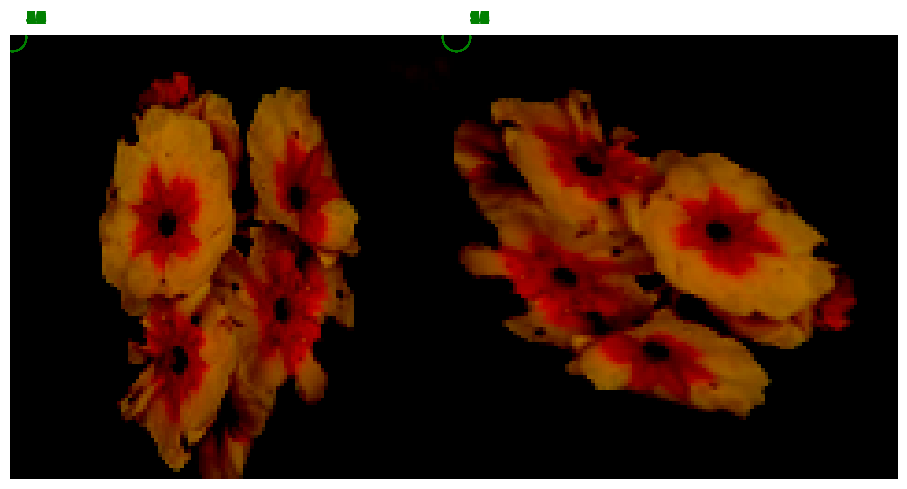

tensor(1., device='cuda:0', grad_fn=<ToCopyBackward0>)

In [65]:
INDEX =1
lista_correspondencias = find_matching_in_batch(batch_points_t.cpu(),batch_points_t2.cpu(),threshold=4)  
acertos = 0
for correspondencias in lista_correspondencias:
  acertos +=len(correspondencias)

q,p,_ = batch_points_t.shape
total = q*p
print("total de pontos {} acertos {} -- %{}".format(total,acertos,acertos*100/total))

print(batch_points_t2.shape,batch_points_t.shape)
for (idx1,idx2) in lista_correspondencias[INDEX]:
    print(f"points1[{idx1}] -> points2[{idx2}]")
print(f"qtd acertos {len(lista_correspondencias[INDEX])}")
plot_matches_keypoints(img[INDEX].permute(1,2,0), batch_points[INDEX].cpu(), batch_t[INDEX].permute(1,2,0), batch_points_t2[INDEX].cpu(),lista_correspondencias[INDEX])

loss_col = loss_point(lista_correspondencias,n_pontos=POINTS_LIMIT)
loss_col

In [66]:
model.eval()
with torch.no_grad():
  features_key,features_ori,batch_points=predict_all_descritor(img,mask)      
  features_key_t2,features_ori_t2,batch_points_t2 =predict_all_descritor(batch_t,mask_t)# prever os pontos da imagem transformada
  


In [67]:
import torch
import torch.nn as nn
import numpy as np
from skimage import draw

def create_circular_mask(h, w, center=None, radius=None):
    """
    Create a circular mask of shape (h, w).
    :param h: height of the mask
    :param w: width of the mask
    :param center: (x, y) tuple of the center
    :param radius: radius of the circle
    :return: (h, w) binary mask
    """

    if center is None:  # use the middle of the image
        center = (int(w / 2), int(h / 2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w - center[0], h - center[1])
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)
    mask = dist_from_center <= radius
    return mask
  
def get_bounding_boxs(batch,points,size=14):
  '''
  Recebe um lote de imagens e um conjunto de pontos e retorna uma lista de bounding boxs para cada imagem
  '''
  mask = create_circular_mask(size,size)
  half1 = size // 2
  half2 = size - half1
  
  num_batch = batch.shape[0]
  num_layer = batch.shape[1]
  num_poits = points.shape[1]
  bounding_boxs = torch.zeros((num_batch,num_poits,num_layer,size,size),dtype=torch.float32)
  
  for image_idx,image in enumerate(batch):
    for point_idx,point in enumerate(points[image_idx]):
      y, x = map(int, point)
      try:
        bounding_boxs[image_idx,point_idx]=image[:,x - half1:x + half2, y - half1:y + half2]
      except:
        print("erro")
        print(x,y,half1,half2)
  return bounding_boxs*mask

# Cria uma camada de pooling global average
global_avg_pool = nn.AdaptiveAvgPool2d(1)
global_max_pool = nn.AdaptiveMaxPool2d(1)
# Aplica o pooling global average no tensor de entrada
# output = global_avg_pool(x)

In [68]:
PT_IDX = lista_correspondencias[INDEX][0][0]
print(INDEX,PT_IDX)
RADIUS = 10
print(features_key.shape,type(features_key),features_ori.shape,batch_points.shape)

# Uso da função medir_tempo para a primeira linha
sub_key, execution_time_1 = medir_tempo(lambda: get_bounding_boxs(features_key.cpu(), batch_points, size=RADIUS*2))
print("Tempo de execução da primeira linha:", execution_time_1,sub_key.shape)
# Uso da função medir_tempo para a terceira linha
sub_ori, execution_time_3 = medir_tempo(lambda: get_bounding_boxs(features_ori.cpu(), batch_points, size=RADIUS*2))
print("Tempo de execução da terceira linha:", execution_time_3,sub_ori.shape)
subimagem = get_bounding_boxs(img.cpu(),batch_points,size=RADIUS*2)
print(subimagem.shape,sub_key.shape,sub_ori.shape)

plot_images_side_by_side(sub_key[INDEX,PT_IDX].cpu())
plot_images_side_by_side(sub_ori[INDEX,PT_IDX].cpu())
plot_images_side_by_side(subimagem[INDEX,PT_IDX].cpu())
plt.imshow(subimagem[INDEX,PT_IDX].cpu().permute(1,2,0))
plt.show()

avg_g1, execution_time_4 = medir_tempo(lambda: global_avg_pool(sub_key[INDEX]).squeeze())
print(avg_g1.shape,"tempo estimado :",execution_time_4)
print(global_avg_pool(sub_key[INDEX]).squeeze()[PT_IDX])
print(global_max_pool(sub_key[INDEX]).squeeze()[PT_IDX])
print(global_avg_pool(sub_ori[INDEX]).squeeze())
print(global_max_pool(sub_ori[INDEX]).squeeze())




IndexError: list index out of range

In [ ]:
PT_IDX = lista_correspondencias[INDEX][0][1]
print(INDEX,PT_IDX)
print(features_key_t2.shape,features_ori_t2.shape,batch_points_t2.shape)

# Uso da função medir_tempo para a primeira linha
sub_key, execution_time_1 = medir_tempo(lambda: get_bounding_boxs(features_key_t2.cpu(), batch_points_t2, size=RADIUS*2))
print("Tempo de execução da primeira linha:", execution_time_1)
# Uso da função medir_tempo para a terceira linha
sub_ori, execution_time_3 = medir_tempo(lambda: get_bounding_boxs(features_ori_t2.cpu(), batch_points_t2, size=RADIUS*2))
subimagem = get_bounding_boxs(batch_t.cpu(),batch_points_t2,size=RADIUS*2)
print(subimagem.shape)

plot_images_side_by_side(sub_key[INDEX,PT_IDX].cpu())
plot_images_side_by_side(sub_ori[INDEX,PT_IDX].cpu())
plot_images_side_by_side(subimagem[INDEX,PT_IDX].cpu())
plt.imshow(subimagem[INDEX,PT_IDX].cpu().permute(1,2,0))
plt.show()


print(global_avg_pool(sub_key[INDEX]).squeeze()[PT_IDX])
print(global_max_pool(sub_key[INDEX]).squeeze()[PT_IDX])
print(global_avg_pool(sub_ori[INDEX]).squeeze())
print(global_max_pool(sub_ori[INDEX]).squeeze())

In [ ]:
import torch

t = torch.tensor([1, 2, 5,7,8])
id = torch.tensor([2, 0, 1])

# Reordenar o vetor t de acordo com os índices em id
t_reordered = torch.index_select(t, dim=0, index=id)

print("Vetor original:", t)
print("Vetor reordenado:", t_reordered)

In [ ]:
from torch import nn
class Feature(nn.Module):
    def __init__(self,n_channel=8) -> None:
        super().__init__()
        self.n_channel = n_channel
        size_chanel_ori = 8
        #resumir a orientacao de 36 canais
        self.block_orie = nn.Sequential(
            nn.Linear(size_chanel_ori, 72),
            nn.Dropout(0.1),
            nn.LeakyReLU(),
            nn.Linear(72, 72),
            nn.Dropout(0.1),
            nn.LeakyReLU(),
            nn.Linear(72, 8),
            nn.LeakyReLU()
        )
        
    def forward(self,f_key,f_ori):
        if f_ori is None:
            x = f_key
        else:
            x = self.block_orie(f_ori)    
        x = torch.cat((f_key,x),dim=1)
        return x

class Discriminator(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Linear(32, 64),
            nn.Dropout(0.1),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU()
        )

    
    def forward(self,X1,X2)->torch.Tensor:        
        x = X1 - X2
        x = torch.cat((X1,x),dim=1)             
        x = self.block1(x)
        distance = torch.norm(x, dim=1,p=2)
        return distance
    
class Siamese(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.feature_extractor = Feature(n_channel=2)
        self.discriminator = Discriminator()
    
    def forward(self,f1_key,f1_ori,f2_key,f2_ori)->torch.Tensor:
        f1 =self.feature_extractor(f1_key,f1_ori)
        f2 =self.feature_extractor(f2_key,f2_ori)
        return self.discriminator(f1,f2)
    
siamese_model = Siamese()
# x11 = torch.randn(3,8)
# x12 = torch.randn(3,36)
# x21 = torch.randn(3,8)
# x22 = torch.randn(3,36)

# # # distancia = siamese_model.feature_extractor(x11,x12)
# distancia = siamese_model(x11,x12,x11,x12)
# print(distancia.shape,distancia)


In [ ]:
sub_key_1, execution_time_1 = medir_tempo(lambda: get_bounding_boxs(features_key.cpu(), batch_points, size=RADIUS*2))
print("Tempo de execução da primeira linha:", execution_time_1,sub_key.shape)
# Uso da função medir_tempo para a terceira linha
sub_ori_1, execution_time_2 = medir_tempo(lambda: get_bounding_boxs(features_ori.cpu(), batch_points, size=RADIUS*2))
print("Tempo de execução da segunda linha:", execution_time_2,sub_ori.shape)
# Uso da função medir_tempo para a primeira linha
sub_key_2, execution_time_3 = medir_tempo(lambda: get_bounding_boxs(features_key_t2.cpu(), batch_points_t2, size=RADIUS*2))
print("Tempo de execução da terceira linha:", execution_time_3)
# Uso da função medir_tempo para a terceira linha
sub_ori_2, execution_time_4 = medir_tempo(lambda: get_bounding_boxs(features_ori_t2.cpu(), batch_points_t2, size=RADIUS*2))
print("Tempo de execução da quarta linha:", execution_time_4)

''' 
Gerando descritores de imagens, tanto para original como para transformada para validar os resultados
'''
def process_image_data(lista_correspondencias, sub_key_1, sub_ori_1, sub_key_2, sub_ori_2,is_plot=False):
    
    for img_idx,correspondencias in enumerate(lista_correspondencias):
        ids_o = torch.tensor([tupla[0] for tupla in correspondencias])
        box_key1 = torch.index_select(sub_key_1[img_idx], dim=0, index=ids_o)
        box_ori1 = torch.index_select(sub_ori_1[img_idx], dim=0, index=ids_o)
        ids_d = torch.tensor([tupla[1] for tupla in correspondencias])
        box_key2 = torch.index_select(sub_key_2[img_idx], dim=0, index=ids_d)
        box_ori2 = torch.index_select(sub_ori_2[img_idx], dim=0, index=ids_d)
        if img_idx == 0 and is_plot:
            plot_images_side_by_side(box_key1[0].cpu())
            plot_images_side_by_side(box_key2[0].cpu())
            
        # summary_pool = torch.cat([global_avg_pool(box_key1).squeeze(), global_max_pool(box_ori1).squeeze()], dim=1)
        # labels = torch.cat([global_avg_pool(box_key2).squeeze(), global_max_pool(box_ori2).squeeze()], dim=1)

        summary_pool = torch.cat([global_avg_pool(box_key1).squeeze(), global_max_pool(box_key1).squeeze()], dim=1)
        labels = torch.cat([global_avg_pool(box_key2).squeeze(), global_max_pool(box_key2).squeeze()], dim=1)
        
        if img_idx == 0:
            summary_pool_list = summary_pool
            labels_list = labels
        else:
            summary_pool_list=torch.cat([summary_pool_list, summary_pool])
            labels_list=torch.cat([labels_list, labels])

    return summary_pool_list, labels_list

[summary_pool_list, labels_list] , tempo = medir_tempo(lambda: process_image_data(lista_correspondencias, sub_key_1, sub_ori_1, sub_key_2, sub_ori_2,is_plot=True))
print("Tempo de execução da geracao do batch:", tempo, summary_pool_list.shape, labels_list.shape)
print("Vetor de sumarizacao:", summary_pool_list[0], "vetor de labels:", labels_list[0])
torch.concat([summary_pool_list, labels_list], dim=1)


import torch
from torch.utils.data import Dataset, DataLoader

class MeuDataset(Dataset):
    def __init__(self, summary_pool_list, labels_list):
        self.summary = summary_pool_list
        self.labels = labels_list
        
    def __len__(self):
        return len(self.summary )
    
    def __getitem__(self, idx):
        summary = self.summary[idx]
        labels = self.labels[idx]
        # Implemente aqui a lógica para retornar uma amostra do seu conjunto de dados
        return summary, labels

# Crie uma instância do seu conjunto de dados personalizado
meu_dataset = MeuDataset(summary_pool_list, labels_list)

# Crie uma instância do DataLoader usando seu conjunto de dados personalizado
dataloader = DataLoader(meu_dataset, batch_size=80, shuffle=True)


In [ ]:
from torch.nn.functional import pairwise_distance
#Create methods to calculate loss
def loss_fn(output_pos,output_neg):  
      
    margim = 0.5
    zero = torch.tensor(0.,requires_grad=True).to(output_pos.device)
    loss = output_pos - output_neg + margim
    loss = torch.max(torch.tensor(0),loss)
    loss = torch.sum(loss)  # Reduzir para um escalar
    
    # print(output_pos,output_neg,loss)
    return loss

#Create methods to train the model
def train_one_epoch(model, data_loader, optimizer, loss_fn, device='cpu', is_training=True):
    model.train(is_training)
    total_loss = 0.
    # Definir os intervalos de colunas
    int_f_key = range(0, 8)
    int_f_ori = range(8, 16)
    for data in data_loader:
        #extrair as features e orientações
        batch_in,batch_out = data[0].to(device),data[1].to(device)
        feat1, orie1, feat2, orie2=batch_in[:,int_f_key], batch_in[:,int_f_ori], batch_out[:,int_f_key], batch_out[:,int_f_ori] 
        orie1,orie2=None,None #quero ignorar o uso das orientações
        #predição no cenário positivo                
        output_pos = model(feat1, orie1, feat2, orie2)
        # print(feat1.shape, orie1.shape, feat2.shape, orie2.shape,output_pos.shape)
        # result1 = bidirectional_match(batch_in, batch_out)
        # print(result1)
        #predição no cenário negativo
        batch_out_neg = torch.roll(batch_out, 1, 0)
        feat2_neg, orie2_neg = batch_out[:,int_f_key], batch_out[:,int_f_ori]
        orie1,orie2=None,None #quero ignorar o uso das orientações
        output_neg = model(feat1, orie1, feat2_neg, orie2_neg)

        
        #calcular a loss
        loss = loss_fn(output_pos, output_neg)
        
        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        total_loss += loss.item()

    return total_loss / len(data_loader.dataset)


- A rede siamesa teve bons resultados , utilizando o pool de features , mas quando utilizavamos a orientação o resultado nao convergia

In [ ]:
siamese_model = Siamese()
optimizer_siamese = optim.Adam(siamese_model.parameters(), lr=0.001, weight_decay=0.0001)

print(summary_pool_list.shape, labels_list.shape)
for i in range(10):
    train_loss = train_one_epoch(siamese_model,dataloader , optimizer_siamese, loss_fn, device='cpu', is_training=True)
    print(train_loss)
# with torch.no_grad():
#     test_loss = train_one_epoch(siamese_model, [summary_pool_list, labels_list], optimizer_siamese, loss_fn, device='cpu', is_training=False)

- Utilizando força bruta com pool avg e max de features obtemos resultados muito similares

In [ ]:
import torch

def bidirectional_match(feat1, feat2):
    # Converter para tipo de ponto flutuante
    feat1 = feat1.float()
    feat2 = feat2.float()

    # Cálculo das diferenças entre pares de elementos
    diff = feat1.unsqueeze(1) - feat2.unsqueeze(0)

    # Cálculo da distância Euclidiana
    dist_matrix = torch.norm(diff, p=2, dim=2)

    # Encontrar os índices dos elementos mais próximos em ambas as direções
    min_indices_feat1_to_feat2 = torch.argmin(dist_matrix, dim=1)
    min_indices_feat2_to_feat1 = torch.argmin(dist_matrix, dim=0)

    # Consolidar as correspondências únicas
    matches = []
    for i, match_index in enumerate(min_indices_feat1_to_feat2):
        if min_indices_feat2_to_feat1[match_index] == i:
            matches.append((i, match_index.item()))

    return matches


    
matches= bidirectional_match(summary_pool_list, labels_list)
acertos = len([match for match in matches if match[0] == match[1]])
perc_match = acertos/len(matches)
perc_total = acertos/len(summary_pool_list)
print(perc_match,perc_total,matches)
# Imprimir as correspondências únicas
# for match in result:
#     print(f"Elemento {match[0]} de feat1 corresponde ao elemento {match[1]} de feat2")


Vamos juntar a predicao que me dar os mapas e os pontos com a estratégia deterministica que me retorna as correspondencias dos pontos atraves dos bounding box dos mapas
- predicao da imagem
- extracao dos bounding box e seus pools
- correspondencia local dos pontos entre duas imagens
- verificar quais images tiveram melhor correspondencia


In [ ]:
model.eval()
with torch.no_grad():
  features_key,features_ori,batch_points=predict_all_descritor(img,mask)      
  features_key_t2,features_ori_t2,batch_points_t2 =predict_all_descritor(batch_t,mask_t)# prever os pontos da imagem transformada



#nao uso as posicoes dos pontos, extraio o vetor de caracteristicas
sub_key_1, execution_time_1 = medir_tempo(lambda: get_bounding_boxs(features_key.cpu(), batch_points, size=RADIUS*2))
print("Tempo extrair bounding box:", execution_time_1,sub_key_1.shape)
# Uso da função medir_tempo para a primeira linha
sub_key_2, execution_time_2 = medir_tempo(lambda: get_bounding_boxs(features_key_t2.cpu(), batch_points_t2, size=RADIUS*2))
print("Tempo extrair bounding box:", execution_time_2,sub_key_2.shape)


INDEX1= INDEX
INDEX2= INDEX+0
summary_pool = torch.cat([global_avg_pool(sub_key_1[INDEX1]).squeeze(), global_max_pool(sub_key_1[INDEX1]).squeeze()], dim=1)
labels = torch.cat([global_avg_pool( sub_key_2[INDEX2]).squeeze(), global_max_pool( sub_key_2[INDEX2]).squeeze()], dim=1)
matches_entre_duas_imagens = bidirectional_match(summary_pool, labels)
print(matches_entre_duas_imagens)


print("Correspondencias com base unicamente no vetor de caracteristica")
plot_matches_keypoints(img[INDEX1].permute(1,2,0), batch_points[INDEX1].cpu(), batch_t[INDEX2].permute(1,2,0), batch_points_t2[INDEX2].cpu(),matches_entre_duas_imagens)
print("Correspondencias com base na transformação ocorrida")
print(lista_correspondencias[INDEX1])
plot_matches_keypoints(img[INDEX1].permute(1,2,0), batch_points[INDEX1].cpu(), batch_t[INDEX2].permute(1,2,0), batch_points_t2[INDEX2].cpu(),lista_correspondencias[INDEX])

In [ ]:
def find_correspondencia_global(model, img, mask, batch_t, mask_t,is_plot=False):
    model.eval()
    with torch.no_grad():
        features_key, features_ori, batch_points = predict_all_descritor(img, mask)
        features_key_t2, features_ori_t2, batch_points_t2 = predict_all_descritor(batch_t, mask_t)
    
    sub_key_1, execution_time_1 = medir_tempo(lambda: get_bounding_boxs(features_key.cpu(), batch_points, size=RADIUS*2))
    sub_key_2, execution_time_2 = medir_tempo(lambda: get_bounding_boxs(features_key_t2.cpu(), batch_points_t2, size=RADIUS*2))
    
    size_list1 = sub_key_1.shape[0]
    size_list2 = sub_key_2.shape[0]
    
    # Inicializar matriz de distâncias com zeros
    dist_matrix = np.zeros((size_list1, size_list2))
    
    for i in range(size_list1):
        summary_pool = torch.cat([global_avg_pool(sub_key_1[i]).squeeze(), global_max_pool(sub_key_1[i]).squeeze()], dim=1)
        for j in range(size_list2):
            labels = torch.cat([global_avg_pool(sub_key_2[j]).squeeze(), global_max_pool(sub_key_2[j]).squeeze()], dim=1)
            matches_entre_duas_imagens = bidirectional_match(summary_pool, labels)
            dist_matrix[i, j] = len(matches_entre_duas_imagens)
            # dist_matrix[j, i] = len(bidirectional_match(summary_pool, summary_pool))
            
            if len(matches_entre_duas_imagens) > 15 and is_plot:
                print(i,j,matches_entre_duas_imagens)
                plot_matches_keypoints(img[i].permute(1,2,0), batch_points[i].cpu(), batch_t[j].permute(1,2,0), batch_points_t2[j].cpu(),matches_entre_duas_imagens)
                
    # Encontrar os índices dos elementos mais próximos em ambas as direções
    max_img_to_batcht = np.argmax(dist_matrix, axis=1)
    max_batcht_to_img = np.argmax(dist_matrix, axis=0)

    # Consolidar as correspondências únicas
    matches = []
    for i, match_index in enumerate(max_img_to_batcht):
        if max_batcht_to_img[match_index] == i:
            matches.append((i, match_index.item()))              
    return matches

# batch_tx=torch.roll(batch_t, 1, 0)
# print(batch_tx.shape,batch_t.shape)

gc.collect()
torch.cuda.empty_cache()
simple_transformations = K.AugmentationSequential(
    K.RandomAffine(degrees=180, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=10,p=0.8),
    same_on_batch=True,
    data_keys = ['input','input']  # Especificando as chaves de dados
)

loader_feature = torch.utils.data.DataLoader(reduced_testset, batch_size=25,
                                        shuffle=False, num_workers=2)
with torch.no_grad():
    is_plot=False
    tqdm_loader = tqdm(loader_feature,position=0, leave=True,desc='Calculando correspondencias entre artefatos')
    for batch_image, labels in tqdm_loader:
        batch_image = batch_image.to(device)
        mask = criar_mascara(batch_image.shape[0],batch_image.shape[-1],args.border_size).to(device)       
        batch_image_trans,mask_trans= simple_transformations(batch_image,mask)# transformar orientacoes e pontos
        match_imgs =find_correspondencia_global(model,batch_image,mask,batch_image_trans,mask_trans,is_plot=is_plot)
        acertos += len([match for match in match_imgs if match[0] == match[1]])
        total += len(match_imgs)
        # print(match_imgs,len(match_imgs))
        is_plot = False
    #exibir total de acertos e percentual
    print("acertos:",acertos," total:",total," percentual:",acertos/total)
        